In [5]:
import numpy as np
import credentials
import glob
import requests
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import boto3

In [7]:
# I didn't installed AWS CLI
print("AWS_ACCESS_KEY_ID:", os.environ.get('AWS_ACCESS_KEY_ID'))
print("AWS_SECRET_ACCESS_KEY:", os.environ.get('AWS_SECRET_ACCESS_KEY'))

AWS_ACCESS_KEY_ID: None
AWS_SECRET_ACCESS_KEY: None


In [8]:
from credentials import AWS_ACCESS_KEY, AWS_SECRET_ACCESS_KEY, AWS_REGION

# Specify the bucket name
bucket_name = 'facial-detection-app'

# Create an S3 client with the specified credentials
s3 = boto3.client('s3', aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

# List all objects in the bucket
response = s3.list_objects(Bucket=bucket_name)

# Print the object keys
for obj in response.get('Contents', []):
    print(obj['Key'])

test.txt


In [35]:
# Info, each metadata file contains this information
"""<image name i>
<number of faces in this image =im>
<face i1>
<face i2>
...
<face im>
...

Here, each face is denoted by:
<major_axis_radius minor_axis_radius angle center_x center_y 1>.
"""

'<image name i>\n<number of faces in this image =im>\n<face i1>\n<face i2>\n...\n<face im>\n...\n\nHere, each face is denoted by:\n<major_axis_radius minor_axis_radius angle center_x center_y 1>.\n'

In [37]:
data_src = "temp_data/"
meta_data_source = "temp_data/FDDB-folds"

files = np.sort([x for x in glob.glob(meta_data_source + "*/*") if x.find("ellipse") > 0])
for file in files:
    with open(file, 'r') as f:
        lines = f.readlines()
    lines = [x.strip() for x in lines]

In [38]:
def split_list_on_element(input_list, split_element='/'):
    result = []
    sublist = []

    for item in input_list:
        if item.find(split_element) > 0:
            if sublist:
                result.append(sublist)
                sublist = [item]
            else:
                sublist.append(item)
        else:
            sublist.append(item)

    if sublist:
        result.append(sublist)

    return result


In [39]:
sublists = split_list_on_element(lines, split_element = "/")
len(sublists)

280

In [40]:
def map_list_to_json(x):
    return {
        'image_name': os.path.join(data_src, x[0]),
        'num_faces': int(x[1]),
        'faces': x[2:],
        'train_set': False
    }

# Make this into lambda function
jsons = list(map(map_list_to_json, sublists))
jsons[0]

{'image_name': 'temp_data/2002/08/31/big/img_18008',
 'num_faces': 4,
 'faces': ['53.968100 38.000000 -1.494904 31.598276 55.596600  1',
  '56.000000 37.000000 -1.460399 202.152999 122.034200  1',
  '54.558400 39.000000 1.396263 293.611040 133.853600  1',
  '44.000000 34.000000 -1.442216 391.131100 168.266900  1'],
 'train_set': False}

In [41]:
def query_document_in_mongoDB(key_to_search, value_to_search):
    url = f"https://eu-central-1.aws.data.mongodb-api.com/app/data-rtppd/endpoint/data/v1/action/findOne"
    payload = json.dumps({
         "collection": credentials.MONGO_COLLECTION_NAME,
        "database": credentials.MONGO_DB_NAME,
        "dataSource": credentials.MONGO_DATA_SOURCE,
        "filter": {key_to_search: value_to_search}
    })
    response = requests.request("POST", url, headers=credentials.HEADERS, data=payload)
    return response.text


def insert_document_in_mongoDB(json_entry):
    
    r = query_document_in_mongoDB(key_to_search='image_name', value_to_search=json_entry['image_name']) 
    if r != '{"document":null}':
        print('Document already exists with path: ' + json_entry['image_name'])
        return None
        
    else:
        url = f"https://eu-central-1.aws.data.mongodb-api.com/app/data-rtppd/endpoint/data/v1/action/insertOne"
        payload = json.dumps({
            "collection": credentials.MONGO_COLLECTION_NAME,
            "database": credentials.MONGO_DB_NAME,
            "dataSource": credentials.MONGO_DATA_SOURCE,
            "document": json_entry
        })
        response = requests.request("POST", url, headers=credentials.HEADERS, data=payload)
        return response.text




In [42]:
# insert_document_in_mongoDB(jsons[1])
for json_document in jsons:
    r = insert_document_in_mongoDB(json_entry=json_document)
    break


Document already exists with path: temp_data/2002/08/31/big/img_18008


In [44]:
s = query_document_in_mongoDB(key_to_search="image_name", value_to_search=jsons[0]['image_name'])


In [55]:
# Read the image file into memory
image_file_path = 'temp_data/2002/08/31/big/img_18008.jpg'
with open(image_file_path, 'rb') as file:
    image_data = file.read()

# Convert image_data to dense array
nparr = np.fromstring(image_data, np.uint8)
img_np = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
dense_array = img_np
plt.imshow(dense_array)


/var/folders/zs/5y34yg7s7h990qqn62f8n4q00000gn/T/ipykernel_24901/2351028442.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(image_data, np.uint8)


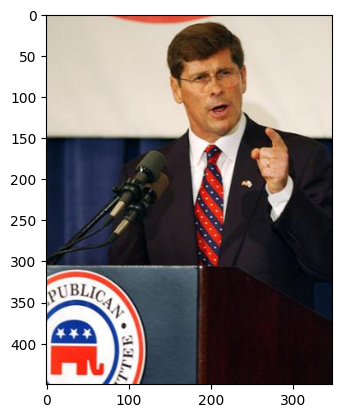

In [70]:
import boto3
# Create AWS session
session = requests.Session()

# Set up the S3 client
bucket_name = 'facial-detection-app'
s3 = boto3.resource('s3')
s3.meta.client.upload_file(image_file_path, bucket_name, image_file_path)


NoCredentialsError: Unable to locate credentials